# 6D Pose PipeLine Demo

## Introduction

In this notebook we'll be performing a quick version of the 6D pose estimation solution implemented by this project. The process is similar to the flow contained in an iteration of the pipeLine.py evalModels function.

The goal of this demonstration is to give the reader a more clear insight into how the data is treated throughout the process of transfroming an RBB image into a set of 3D coordinates detailing the position of an object.

(480, 640, 3)
['0.550160', '0.453051', '0.582045', '0.422501', '0.576548', '0.340727', '0.581922', '0.545906', '0.576019', '0.471720', '0.526955', '0.425004', '0.515958', '0.344182', '0.523314', '0.547548', '0.511146', '0.474219']


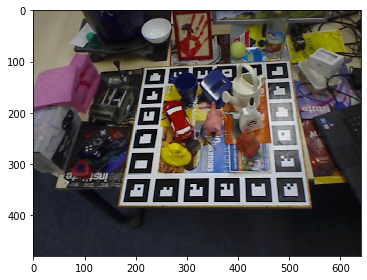

In [10]:
import sys

import tensorflow as tf, numpy as np, matplotlib.pyplot as plt, random, math, statistics, os
from skimage.io import imshow
import data

image, labels = data.getDataSplitImage(True) # Loading a random image from the validation data set

print(image.shape) # an rgb image of dimensions 480 x 640 x 3
print(labels) # a labels file detailing x, y coordinates for 9 2d keypoints on our loaded image

def showImage(img): # displays image using plt
	plt.figure()
	imshow(np.squeeze(img))
	plt.show()
    
showImage(image)

We now have our image, and a list containing info for the corresponding 2d bounding box keypoints. Let's load the models we'll be using to generate our predictions for unit vector and class outputs.

In [ ]:

import models

# loading our model to predict unit vectors per pixel per keypoint on image
vecModel = models.stvNetNew(outVectors = True, outClasses = False)
vecModel.load_weights('models\\stvNet_new_coords_cat') # loading weights for standard labels model
vecModel.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.Huber())

# loading our class model for image segmentation
classModel = models.uNet(outVectors = False, outClasses = True)
classModel.load_weights('models\\uNet_classes_cat')
classModel.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.BinaryCrossentropy())

# loading our combined model which outputs both predictions together TODO change to stvNetNew later
combModel = models.stvNet(outVectors = True, outClasses = True)
combModel.load_weights('models\\stvNet_cat') # loading weights for standard labels model
combModel.compile(optimizer = tf.keras.optimizers.Adam(), loss = {'coordsOut': tf.keras.losses.Huber(), 'classOut': tf.keras.losses.BinaryCrossentropy()})

Now our models are ready to make predictions using our random image.

(480, 640, 18)


C:\Users\Stephen\Anaconda3\envs\stvNet\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


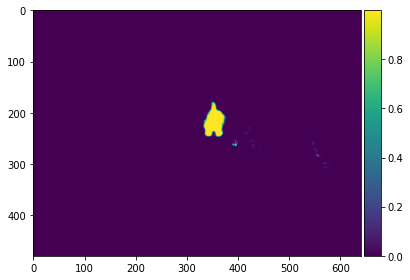

In [12]:
#  generating predictions

nnInput = np.array([image])

vecPred = vecModel.predict(nnInput)[0]
classPred = classModel.predict(nnInput)[0]
combPred = combModel.predict(nnInput)

print(vecPred.shape)
showImage(classPred) # let's see our uNet model output

## Model Prediction Results

We can see that our vector prediction has a shape that matches our photo dimensions in width and height, but has 18 values for each pixel. Each value represents an x or y component for our unit vector predictions for each of the 9 keypoints we are looking for.

Our class prediction has (hopefully) found the pixels associated with our object of interest. We can now filter for these pixels and use the associated vector predictions for our ransac voting process.

In [13]:
population = np.where(classPred > .9)[:2]
population = list(zip(population[0], population[1]))

print(len(population)) # the number of class pixels found

1457


## RanSaC Voting

Our RanSaC voting algorithm is more complex than what we've done up until this point. The goal of the algorithm is to use our predictions on our pixels of interest, to generate a list of hypotheses, and an associated weight for each hypothesis which indicates how well the prediction 'fits' the rest of the data.

This is done by taking two pixels from our population at random, and for each keypoint, find the intersection of the lines given by our unit vector predictions for each keypoint, which will be used as our hypothesis. This process also involves a fairly intimidating-looking if statement, which checks that our hypothesis was generated on the correct side  of the two queried pixels according to their unit vector predictions.

We then see how well this hypothesis aligns with the rest of the population. For every other pixel of interest, we see find the unit vector between our hypothesis and the pixel, and see how similar the real unit vector is to the unit vector predicted by our vector model. We can do this by taking the dot product of the two unit vectors, which will have a value between 1 and -1. One for unit vectors pointing in the same direction, and -1 for the opposite direction.

If this value is above a certain threshold, in this case .99, we increment the weight value for the hypothesis. We can then use this weight value to determine which hypotheses best fit the rest of the population data.

In [14]:
# RanSaC Voting

def ransacVal(y1, x1, v2): # dot product of unit vectors to find cos(theta difference)
	v2 = v2 / np.linalg.norm(v2)
	
	return y1 * v2[1] + x1 * v2[0]

hypDict = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}

for n in range(50): #take two pixels, find intersection of unit vectors
    #print(n)
    p1 = population.pop(random.randrange(len(population)))
    v1 = vecPred[p1[0]][p1[1]]
    p2 = population.pop(random.randrange(len(population)))
    v2 = vecPred[p2[0]][p2[1]]
    #print(p1, p2)
    #print(v1, v2)
    for i in range(9): # find lines intersection, use as hypothesis
        m1 = v1[i * 2 + 1] / v1[i * 2]
        m2 = v2[i * 2 + 1] / v2[i * 2]
        b1 = p1[0] - p1[1] * m1
        b2 = p2[0] - p2[1] * m2
        x = (b2 - b1) / (m1 - m2)
        y = m1 * x + b1
        if (y >= p1[0] != v1[i * 2 + 1] < 0 or x >= p1[1] != v1[i * 2] < 0 or y >= p2[0] != v2[i * 2 + 1] < 0 or y >= p2[1] != v2[i * 2] < 0) or not (m1 - m2): # check if line intersection takes place according to unit vector directions
            continue
        #print(y, x)
        weight = 0
        for voter in population: # voting for fit of hypothesis
            yDiff = y - voter[0]
            xDiff = x - voter[1]

            mag = math.sqrt(yDiff ** 2 + xDiff ** 2)
            vec = vecPred[voter[0]][voter[1]][i * 2: i * 2 + 2]

            if ransacVal(yDiff / mag, xDiff / mag, vec) > .99:
                weight += 1
        hypDict[i].append(((y, x), weight))

    population.append(p1)
    population.append(p2)
    
print(hypDict[0])

[((220.577357943327, 352.2445490498656), 1046), ((221.34934271253007, 351.3366916668965), 947), ((217.79865202173968, 352.1098897389505), 1237), ((217.6574533895532, 352.2544046575786), 1223), ((217.96617463137727, 352.5869269274098), 1275), ((213.5810216783484, 354.7123521606857), 528), ((219.19276223224995, 353.4759992284453), 1169), ((222.4407783066854, 351.31438235303114), 852), ((218.85844169015797, 351.27354752508523), 1177), ((219.70558006400643, 350.85667017644454), 1050), ((215.53595989286123, 349.1660322566833), 527), ((215.34366420713832, 352.6051794457502), 796), ((217.13048469756052, 350.8336028398383), 984), ((218.98415367591812, 356.3485925913178), 381), ((229.91734529675284, 348.461333355244), 417), ((225.2604587297783, 350.2751798559185), 612), ((217.64547598294303, 351.8956256553884), 1199), ((222.01912550980137, 351.1251487190544), 883), ((218.34057355294308, 355.6383040601597), 543), ((220.00854807111295, 351.3710896462176), 1083), ((222.64265378202953, 349.28688100

Now we have a dictionary with a key / value pair for each keypoint. Each value contains a list of coordinates, each with an associated weight indicating the 'fit' of that keypoint to the rest of the popluation.

I've found that better performance can be achieved by pruning some of the outlying values from these hypotheses, one method is to find the mean, and standard deviation values for each keypoint, and prune those that lie outside a certain range.

In [15]:
def pruneHypsStdDev(hypDict, m = 2): # prune generated hypotheses using mean and stdDev
	for key, hyps in hypDict.items():
		yVals, xVals = [x[0][0]for x in hyps], [x[0][1]for x in hyps]
		yMean, xMean = statistics.mean(yVals), statistics.mean(xVals)
		yDev, xDev = statistics.pstdev(yVals) * m, statistics.pstdev(xVals) * m
		hypDict[key] = [x for x in hyps if not determineOutlier(x[0], yMean, yDev, xMean, xDev)]
        
def determineOutlier(input, yMean, yDev, xMean, xDev):
	return abs(input[0] - yMean) > yDev or abs(input[1] - xMean) > xDev
        
pruneHypsStdDev(hypDict)

Now we need our keypoints to use to solve our PnP problem. This can be done my taking a weighted average of the hypotheses for each of the keypoints.

In [16]:
def getMean(hypDict): # get weighted average of coordinates
	meanDict = {}
	for key, hyps in hypDict.items():
		xMean = 0
		yMean = 0
		totalWeight = 0
		for hyp in hyps:
			yMean += hyp[0][0] * hyp[1]
			xMean += hyp[0][1] * hyp[1]
			totalWeight += hyp[1]
		yMean /= totalWeight
		xMean /= totalWeight
		meanDict[key] = [yMean, xMean]
	return meanDict

meanDict = getMean(hypDict)

print(meanDict)

{0: [218.9258084873802, 352.0342145158551], 1: [203.43639780909504, 376.9754670214536], 2: [161.10272891179494, 368.90756837480353], 3: [258.986324896387, 371.4615025092094], 4: [224.37462008892498, 373.1033071074115], 5: [203.8210260312048, 330.97969757816776], 6: [162.23686833504638, 327.24980101680194], 7: [262.7347384800706, 334.3068651572184], 8: [224.6343140705197, 330.45027466592785]}


## PnP Solver

With our 9 keypoints, we are now ready to solve the PnP problem. First we load the corresponding 3d keypoints for the 2d keypoints we have found, then we can use cv2 to find the camera position relative to the object.

In [17]:
def dictToArray(hypDict): # take dictionary keypoints and return list object
	coordArray = np.zeros((len(hypDict.keys()), 2))
	for key, hyps in hypDict.items():
		coordArray[key] = np.array([round(hyps[1]), round(hyps[0])]) # x, y format
	return coordArray

pts3d = np.loadtxt(os.path.join(os.getcwd() + '\\LINEMOD\\cat\\', 'bb8_3d.txt'))
preds = dictToArray(meanDict)[1:] # ignoring centroid prediction
matrix = np.array([[572.4114, 0., 325.2611], [0., 573.57043, 242.04899], [0., 0., 1.]]) #  input camera matrix for the kinect camera

import cv2

_, rVec, tVec = cv2.solvePnP(pts3d, preds, matrix, np.zeros(shape=[8, 1], dtype='float64'), flags = cv2.SOLVEPNP_ITERATIVE)

print(rVec) # output rotation vector
print(tVec) # output translation vector

[[-2.46373625]
 [ 0.05752149]
 [-0.00281926]]
[[-0.04450775]
 [ 0.04279864]
 [-0.96412502]]


## Results

Now that we have our rotation and translation vectors, we can perform a sort of inverse process and impose a 3d object on our 2d image using the cv2 projectPoints function. We can then check our accuracy, and even draw the true and predicted bounding boxes on the original image to get a visual indication of our accuracy.

[[374.4529627  200.87285294]
 [368.72156171 161.70266086]
 [373.47071611 263.04172775]
 [368.25595848 221.45994832]
 [331.36930178 202.7350713 ]
 [329.65915239 163.42493558]
 [333.93803667 264.69644451]
 [332.13522688 223.00506199]]


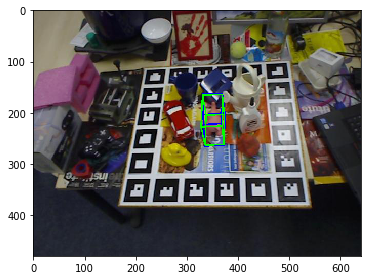

Prediction Accuracy - MAE: 2.21, MSE 8.03


In [18]:
yPred = cv2.projectPoints(pts3d, rVec, tVec, matrix, np.zeros(shape=[8, 1], dtype='float64'))[0]
yPred = np.squeeze(yPred)

print(yPred)

yTrue = data.labelFloatsToPixels(labels, decPlace = 8)[1::] # converting our labels to pixel values

def labelDrawPoints(drawList): # (b, f = back, front), (l, r = left, right), (u, d = up , down)
	drawDict = {}
	drawDict['bld'] = (int(round(drawList[0][0])), int(round(drawList[0][1])))
	drawDict['blu'] = (int(round(drawList[1][0])), int(round(drawList[1][1])))
	drawDict['fld'] = (int(round(drawList[2][0])), int(round(drawList[2][1])))
	drawDict['flu'] = (int(round(drawList[3][0])), int(round(drawList[3][1])))
	drawDict['brd'] = (int(round(drawList[4][0])), int(round(drawList[4][1])))
	drawDict['bru'] = (int(round(drawList[5][0])), int(round(drawList[5][1])))
	drawDict['frd'] = (int(round(drawList[6][0])), int(round(drawList[6][1])))
	drawDict['fru'] = (int(round(drawList[7][0])), int(round(drawList[7][1])))
	return drawDict

def drawPose(img, drawPoints, colour = (255,0,0)): # draw bounding box
	
	cv2.line(img, drawPoints['bld'], drawPoints['blu'], colour, 2)
	cv2.line(img, drawPoints['bld'], drawPoints['fld'], colour, 2)
	cv2.line(img, drawPoints['bld'], drawPoints['brd'], colour, 2)
	cv2.line(img, drawPoints['blu'], drawPoints['flu'], colour, 2)
	cv2.line(img, drawPoints['blu'], drawPoints['bru'], colour, 2)
	cv2.line(img, drawPoints['fld'], drawPoints['flu'], colour, 2)
	cv2.line(img, drawPoints['fld'], drawPoints['frd'], colour, 2)
	cv2.line(img, drawPoints['flu'], drawPoints['fru'], colour, 2)
	cv2.line(img, drawPoints['fru'], drawPoints['bru'], colour, 2)
	cv2.line(img, drawPoints['fru'], drawPoints['frd'], colour, 2)
	cv2.line(img, drawPoints['frd'], drawPoints['brd'], colour, 2)
	cv2.line(img, drawPoints['brd'], drawPoints['bru'], colour, 2)

img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
drawPose(img, labelDrawPoints(yPred))
drawPose(img, labelDrawPoints(yTrue), (0,255,0))
showImage(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#cv2.imshow("Output", img)

print("Prediction Accuracy - MAE: {0}, MSE {1}".format(round(tf.reduce_mean(tf.keras.metrics.mean_absolute_error(yTrue, yPred)).numpy(), 2), round(tf.reduce_mean(tf.keras.metrics.mean_squared_error(yTrue, yPred)).numpy(), 2)))

## Conclusion

This gives us our final output values for this process, and can be used to generated a number of accuracy metrics, as well as the photo rendered above. Hopefully this demo was useful in understanding this process, and gives some insight into some of the techniques and concepts used in computer vision. Thanks for reading!